# ADA Project
## Data Analysis

## 1. ARIMA

--> use auto_arima, lat and long, per wolf, 80/20 regular split for training, prediction must be in continuity with the time line, last N*10% or last 2 weeks predicted, compare with real last 10% of obs., timeline important because I want to compare the predictions of the last two weeks and the real last two weeks

/var/folders/cd/f_ps01dx04n4r8lqhy1tjk5r0000gn/T/ipykernel_883/3027571389.py:9: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)
/Users/robin/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/robin/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/robin/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/robin/opt/anaconda3/lib/python3.9/

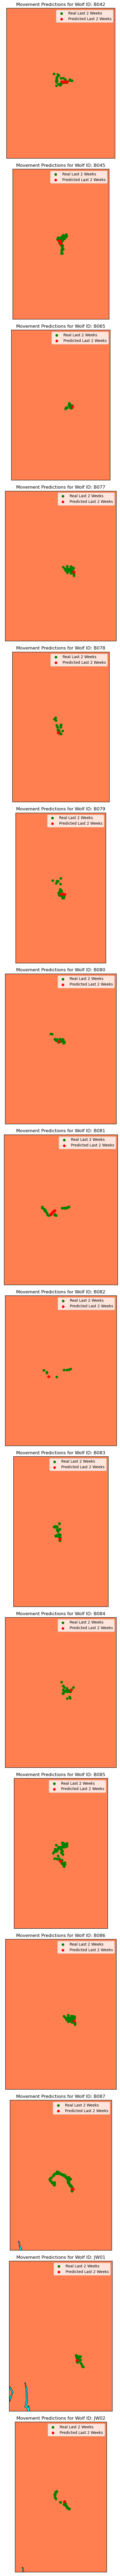

In [1]:
import pandas as pd
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Load the dataset
file_path = '/Users/robin/Library/Mobile Documents/com~apple~CloudDocs/UNIL/HEC cours/Master/MA 2/Advandced Data Analysis/Project/Data/merged_data.csv'
data = pd.read_csv(file_path)
data = data[data['animal-type'] == 'Wolf']
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.sort_values(['individual-id', 'timestamp'], inplace=True)

# Assuming there are multiple wolves (individual-ids)
individual_ids = data['individual-id'].unique()

# Preparing the figure for plotting
fig, axs = plt.subplots(nrows=len(individual_ids), figsize=(10, 6 * len(individual_ids)))

for ax, individual_id in zip(axs, individual_ids):
    wolf_data = data[data['individual-id'] == individual_id]
    
    # Assuming we're focusing on the last two weeks for the test set
    split_date = wolf_data['timestamp'].max() - pd.Timedelta(weeks=2)
    train_data = wolf_data[wolf_data['timestamp'] < split_date]
    test_data = wolf_data[wolf_data['timestamp'] >= split_date]

    # Model for latitude
    model_lat = auto_arima(train_data['location-lat'], seasonal=False, stepwise=True)
    # Model for longitude
    model_long = auto_arima(train_data['location-long'], seasonal=False, stepwise=True)

    # Making predictions for the test set period
    pred_lat = model_lat.predict(n_periods=len(test_data))
    pred_long = model_long.predict(n_periods=len(test_data))

    # Map plotting
    m = Basemap(projection='merc', llcrnrlat=train_data['location-lat'].min() - 1,
                urcrnrlat=train_data['location-lat'].max() + 1,
                llcrnrlon=train_data['location-long'].min() - 1,
                urcrnrlon=train_data['location-long'].max() + 1, lat_ts=20, resolution='i', ax=ax)

    m.drawcoastlines()
    m.drawcountries()
    m.fillcontinents(color='coral', lake_color='aqua')
    m.drawmapboundary(fill_color='aqua')

    # Real movements
    x_real, y_real = m(test_data['location-long'].values, test_data['location-lat'].values)
    m.scatter(x_real, y_real, color='green', label='Real Last 2 Weeks', zorder=5)

    # Predicted movements
    x_pred, y_pred = m(pred_long, pred_lat)
    m.scatter(x_pred, y_pred, color='red', label='Predicted Last 2 Weeks', zorder=5)

    ax.set_title(f"Movement Predictions for Wolf ID: {individual_id}")
    ax.legend()

plt.tight_layout()
plt.show()


In [9]:
import pandas as pd
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Load and prepare your data
data = pd.read_csv('/Users/robin/Library/Mobile Documents/com~apple~CloudDocs/UNIL/HEC cours/Master/MA 2/Advandced Data Analysis/Project/Data/merged_data.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.sort_values(['individual-id', 'timestamp'], inplace=True)

# Process each wolf's data
results = {}
for wolf_id, group in data.groupby('individual-id'):
    # Split data into 90% for train-test and 10% for independent forecast
    initial_train_data, forecast_data = train_test_split(group, test_size=0.1, shuffle=False)

    # Split the initial 90% into training and testing data (80/20 split)
    train_data, test_data = train_test_split(initial_train_data, test_size=0.2, shuffle=False)

    # Train ARIMA model on the training data
    model_lat = auto_arima(train_data['location-lat'], seasonal=False, stepwise=True, suppress_warnings=True)
    model_long = auto_arima(train_data['location-long'], seasonal=False, stepwise=True, suppress_warnings=True)

    # Predict on the training set (for training accuracy)
    train_preds_lat = model_lat.predict(n_periods=len(train_data))
    train_preds_long = model_long.predict(n_periods=len(train_data))

    # Predict on the test set (for test accuracy)
    test_preds_lat = model_lat.predict(n_periods=len(test_data))
    test_preds_long = model_long.predict(n_periods=len(test_data))

    # Forecast the last 10% of the data
    forecast_preds_lat = model_lat.predict(n_periods=len(forecast_data))
    forecast_preds_long = model_long.predict(n_periods=len(forecast_data))

    # Compute accuracy metrics for all sets
    train_mae_lat = mean_absolute_error(train_data['location-lat'], train_preds_lat)
    train_rmse_lat = np.sqrt(mean_squared_error(train_data['location-lat'], train_preds_lat))
    train_mae_long = mean_absolute_error(train_data['location-long'], train_preds_long)
    train_rmse_long = np.sqrt(mean_squared_error(train_data['location-long'], train_preds_long))

    test_mae_lat = mean_absolute_error(test_data['location-lat'], test_preds_lat)
    test_rmse_lat = np.sqrt(mean_squared_error(test_data['location-lat'], test_preds_lat))
    test_mae_long = mean_absolute_error(test_data['location-long'], test_preds_long)
    test_rmse_long = np.sqrt(mean_squared_error(test_data['location-long'], test_preds_long))

    forecast_mae_lat = mean_absolute_error(forecast_data['location-lat'], forecast_preds_lat)
    forecast_rmse_lat = np.sqrt(mean_squared_error(forecast_data['location-lat'], forecast_preds_lat))
    forecast_mae_long = mean_absolute_error(forecast_data['location-long'], forecast_preds_long)
    forecast_rmse_long = np.sqrt(mean_squared_error(forecast_data['location-long'], forecast_preds_long))

    # Store results
    results[wolf_id] = {
        'training_accuracy': {'MAE_lat': train_mae_lat, 'RMSE_lat': train_rmse_lat, 'MAE_long': train_mae_long, 'RMSE_long': train_rmse_long},
        'test_accuracy': {'MAE_lat': test_mae_lat, 'RMSE_lat': test_rmse_lat, 'MAE_long': test_mae_long, 'RMSE_long': test_rmse_long},
        'forecast_accuracy': {'MAE_lat': forecast_mae_lat, 'RMSE_lat': forecast_rmse_lat, 'MAE_long': forecast_mae_long, 'RMSE_long': forecast_rmse_long},
        'test_predictions': (test_preds_lat, test_preds_long),
        'forecast_predictions': (forecast_preds_lat, forecast_preds_long),
        'actual_forecast_data': (forecast_data['location-lat'].values, forecast_data['location-long'].values)
    }

# Display results for each wolf
for wolf_id, metrics in results.items():
    print(f"Wolf ID: {wolf_id}")
    print("Training Accuracy:", metrics['training_accuracy'])
    print("Validation set Accuracy:", metrics['test_accuracy'])
    print("Forecast Accuracy:", metrics['forecast_accuracy'])


/var/folders/cd/f_ps01dx04n4r8lqhy1tjk5r0000gn/T/ipykernel_8792/4140503773.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/Users/robin/Library/Mobile Documents/com~apple~CloudDocs/UNIL/HEC cours/Master/MA 2/Advandced Data Analysis/Project/Data/merged_data.csv')


KeyboardInterrupt: 

## 4. LSTM 

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the dataset
file_path = '/Users/robin/Library/Mobile Documents/com~apple~CloudDocs/UNIL/HEC cours/Master/MA 2/Advandced Data Analysis/Project/Data/merged_data.csv'
data = pd.read_csv(file_path)

# Separate wolf and elk data
wolf_data = data[data['animal-type'] == 'Wolf'].sort_values('timestamp')
elk_data = data[data['animal-type'] == 'Elk'].sort_values('timestamp')

# Features: Elk locations, Target: Wolf locations
features = elk_data[['location-lat', 'location-long']].values
target = wolf_data[['location-lat', 'location-long']].values

# Normalize the data
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target)

# Define time_steps and prepare the data sequences
time_steps = 50
x_final, y_final = [], []
for k in range(len(features_scaled) - time_steps):
    x_final.append(features_scaled[k:k + time_steps])
    y_final.append(target_scaled[k + time_steps])

x_final = np.array(x_final)
y_final = np.array(y_final)

# SHUFFLE THE DATA

# Split the data
train_features, test_features, train_target, test_target = train_test_split(x_final, y_final, test_size=0.2, shuffle=False)

# LSTM model
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(time_steps, 2), return_sequences=True),
    tf.keras.layers.LSTM(32, activation='relu'),
    tf.keras.layers.Dense(2)
])

# Compile and fit the model
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse')
history = model.fit(train_features, train_target, epochs=10, validation_data=(test_features, test_target), verbose=1)

# Model summary
model.summary()


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Load the dataset
file_path = '/Users/robin/Library/Mobile Documents/com~apple~CloudDocs/UNIL/HEC cours/Master/MA 2/Advandced Data Analysis/Project/Data/merged_data.csv'
merged_data = pd.read_csv(file_path)

# Align and merge the data based on rounded timestamps
merged_data['rounded_timestamp'] = merged_data['timestamp'].dt.round('H')  # Adjust the rounding as needed
wolf_data = merged_data[merged_data['animal-type'] == 'Wolf']
elk_data = merged_data[merged_data['animal-type'] == 'Elk']

# Merge wolf and elk data on rounded_timestamp
aligned_data = pd.merge(wolf_data, elk_data, on='rounded_timestamp', suffixes=('_wolf', '_elk'))

# Handle missing values
imputer = SimpleImputer(strategy='ffill')
aligned_data[['location-lat_elk', 'location-long_elk']] = imputer.fit_transform(aligned_data[['location-lat_elk', 'location-long_elk']])

# Prepare the feature and target matrices
features = aligned_data[['location-lat_elk', 'location-long_elk']].values
target = aligned_data[['location-lat_wolf', 'location-long_wolf']].values

# Normalize the data
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target)

# Define time_steps and prepare the data sequences
time_steps = 50
x_final, y_final = [], []
for k in range(len(features_scaled) - time_steps):
    x_final.append(features_scaled[k:k + time_steps])
    y_final.append(target_scaled[k + time_steps])

x_final = np.array(x_final)
y_final = np.array(y_final)

# Split the data into training and test sets
train_features, test_features, train_target, test_target = train_test_split(x_final, y_final, test_size=0.2, shuffle=False)

# Define the LSTM model
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(time_steps, 2), return_sequences=True),
    tf.keras.layers.LSTM(32, activation='relu'),
    tf.keras.layers.Dense(2)  # Output layer for latitude and longitude
])

# Compile and fit the model
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse')
history = model.fit(train_features, train_target, epochs=10, validation_data=(test_features, test_target), verbose=1)

# Model summary
model.summary()


### LSTM TEST

In [ ]:
import pandas as pd

# Load the dataset
file_path = '/Users/robin/Library/Mobile Documents/com~apple~CloudDocs/UNIL/HEC cours/Master/MA 2/Advandced Data Analysis/Project/Data/clean_data_wolf.csv'
wolves_data = pd.read_csv(file_path)

##### Create the LSTM model

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Convert timestamps to datetime and sort the data chronologically
wolves_data['timestamp'] = pd.to_datetime(wolves_data['timestamp'])
wolves_data.sort_values('timestamp', inplace=True)

# Selecting latitude and longitude as features for the LSTM model
features = wolves_data[['location-lat', 'location-long']].values

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Define the number of timestamps to use in the input sequence
sequence_length = 3

# Split the data into training and test sets (80% train, 20% test)
train_features, test_features = train_test_split(scaled_features, test_size=0.2, shuffle=False)

# Create the TimeseriesGenerator for training and test sets
train_generator = TimeseriesGenerator(train_features, train_features, length=sequence_length, batch_size=1)
test_generator = TimeseriesGenerator(test_features, test_features, length=sequence_length, batch_size=1)

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(sequence_length, 2), return_sequences=False))
model.add(Dense(units=2))  # Output layer with 2 units for latitude and longitude

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Fit the model to the data
history = model.fit(train_generator, epochs=1, verbose=1, validation_data=test_generator)

# Summary of the model architecture
model.summary()


##### Predictions for the first wolf with the model + Haversine accuracy

In [ ]:
# Filter data for the first wolf
first_wolf_data = wolves_data[wolves_data['individual-local-identifier'] == wolves_data['individual-local-identifier'].unique()[0]]

# Extracting relevant features and scaling
first_wolf_features = scaler.transform(first_wolf_data[['location-lat', 'location-long']].values)

# Generating sequences for the first wolf
first_wolf_sequences = TimeseriesGenerator(first_wolf_features, first_wolf_features,
                                           length=sequence_length, batch_size=1)

# Prepare containers for the predictions and actual values
predictions = []
actual = []

# Generate predictions for each sequence
for i in range(len(first_wolf_sequences)):
    x, y = first_wolf_sequences[i]
    yhat = model.predict(x)
    predictions.append(yhat[0])
    actual.append(y[0])

# Inverse the scaling
predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(actual)

# Calculate Haversine distance for each prediction
distances = [haversine((act[0], act[1]), (pred[0], pred[1])) for act, pred in zip(actual, predictions)]

# Calculate the mean distance error
mean_distance_error = sum(distances) / len(distances)

# Output the result
print(f'Mean Haversine Distance Error for the first wolf: {mean_distance_error} kilometers')


##### Computing MAE and RMSE accuracy

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse_lat = sqrt(mean_squared_error(actual[:, 0], predictions[:, 0]))
rmse_long = sqrt(mean_squared_error(actual[:, 1], predictions[:, 1]))
mae_lat = mean_absolute_error(actual[:, 0], predictions[:, 0])
mae_long = mean_absolute_error(actual[:, 1], predictions[:, 1])

print(f'Latitude RMSE: {rmse_lat}')
print(f'Longitude RMSE: {rmse_long}')
print(f'Latitude MAE: {mae_lat}')
print(f'Longitude MAE: {mae_long}')
